# DYNAMIC PRICING ENGINE - JETTO.ID
## Data preparationn


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

### Load data awal

In [2]:

df = pd.read_csv('data.csv', encoding='ISO-8859-1')

print(f"\ndataset berhasil dimuat")
print(f"  Dimensi: {df.shape[0]:,} baris × {df.shape[1]} kolom")

print("\ndata head")
print(df.head(10))

print("\ninfo data") 
print(df.info())

print("\ndescribe data") 
print(df.describe())




dataset berhasil dimuat
  Dimensi: 541,909 baris × 8 kolom

data head
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26 

### Analisis data awal / identifikasi

In [3]:
print("2. analisis data/cek klo ada yg anomali")

print("\nAnalisis Missing Values:")
missing_data = pd.DataFrame({
    'Kolom': df.columns,
    'Jumlah_Missing': df.isnull().sum(),
    'Persentase_Missing': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Jumlah_Missing'] > 0].sort_values('Persentase_Missing', ascending=False)
print(missing_data.to_string(index=False))

duplicates = df.duplicated().sum()
print(f"\nBaris Duplikat: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

print("\nrekap anomali data : ")

negative_qty = (df['Quantity'] < 0).sum()
print(f"• Quantity Negatif (Pengembalian): {negative_qty:,}")

zero_price = (df['UnitPrice'] == 0).sum()
print(f"• Unit Price Nol: {zero_price:,}")

cancelled = df['InvoiceNo'].astype(str).str.startswith('C').sum()
print(f"• Transaksi Dibatalkan: {cancelled:,}")


2. analisis data/cek klo ada yg anomali

Analisis Missing Values:
      Kolom  Jumlah_Missing  Persentase_Missing
 CustomerID          135080               24.93
Description            1454                0.27

Baris Duplikat: 5,268 (0.97%)

rekap anomali data : 
• Quantity Negatif (Pengembalian): 10,624
• Unit Price Nol: 2,515
• Transaksi Dibatalkan: 9,288


### Data cleaning

In [4]:
print("3. data cleaning")

df_clean = df.copy()

df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]
print(f"Menghapus transaksi yang dibatalkan: {len(df) - len(df_clean):,} baris")

df_clean = df_clean[df_clean['Quantity'] > 0]
print(f"Menghapus pengembalian (quantity negatif)")

df_clean = df_clean[df_clean['UnitPrice'] > 0]
print(f"Menghapus harga nol")

df_clean = df_clean.dropna(subset=['Description'])
print(f"Menghapus deskripsi kosong")

df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
print(f"Konversi InvoiceDate ke format datetime")

def remove_outliers_iqr(df, column, multiplier=3.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

original_len = len(df_clean)
df_clean = remove_outliers_iqr(df_clean, 'Quantity', multiplier=3.0)
df_clean = remove_outliers_iqr(df_clean, 'UnitPrice', multiplier=3.0)
print(f"menghapus outlier ekstrem: {original_len - len(df_clean):,} baris")

print(f"\ndimensi Dataset Bersih: {df_clean.shape[0]:,} baris × {df_clean.shape[1]} kolom")


3. data cleaning
Menghapus transaksi yang dibatalkan: 9,288 baris
Menghapus pengembalian (quantity negatif)
Menghapus harga nol
Menghapus deskripsi kosong
Konversi InvoiceDate ke format datetime
menghapus outlier ekstrem: 32,696 baris

dimensi Dataset Bersih: 497,408 baris × 8 kolom


### EDA (Exploratory Data Analysis)
-> untuk memahami pola/karakteristik data

- 1 Temporal Analysis atau analisis pola waktu
- 2 Product Analysis atau analisis produk
- 3 Price Distribution distribusi harga
- 4 Geographic Analysis atau annalisis geografis


In [5]:
df_clean['Revenue'] = df_clean['Quantity'] * df_clean['UnitPrice']
# bikin baru dari quantity x unitprice = revenue
print("4. EXPLORATORY DATA ANALYSIS (EDA)")
print(f"kolom Revenue berhasil dibuat")

df_clean['Revenue']


4. EXPLORATORY DATA ANALYSIS (EDA)
kolom Revenue berhasil dibuat


0         15.30
1         20.34
2         22.00
3         20.34
4         20.34
          ...  
541904    10.20
541905    12.60
541906    16.60
541907    16.60
541908    14.85
Name: Revenue, Length: 497408, dtype: float64

### 4.1 Temporal Analysis
analisis distribusi berdasar waktu (jam, hari, rentang waktu, wekkend/weekday)




4.1 ANALISIS TEMPORAL (TEMPORAL ANALYSIS)
Rentang Tanggal: 2010-12-01 08:26:00 sampai 2011-12-09 12:50:00

Transaksi Berdasarkan Hari:
DayOfWeek
Friday       75215
Monday       87487
Sunday       61845
Thursday     94148
Tuesday      92700
Wednesday    86013
Name: count, dtype: int64

Transaksi Berdasarkan Jam:
Hour
6         1
7       233
8      8016
9     30945
10    43370
11    52298
12    72894
13    67496
14    62453
15    71747
Name: count, dtype: int64


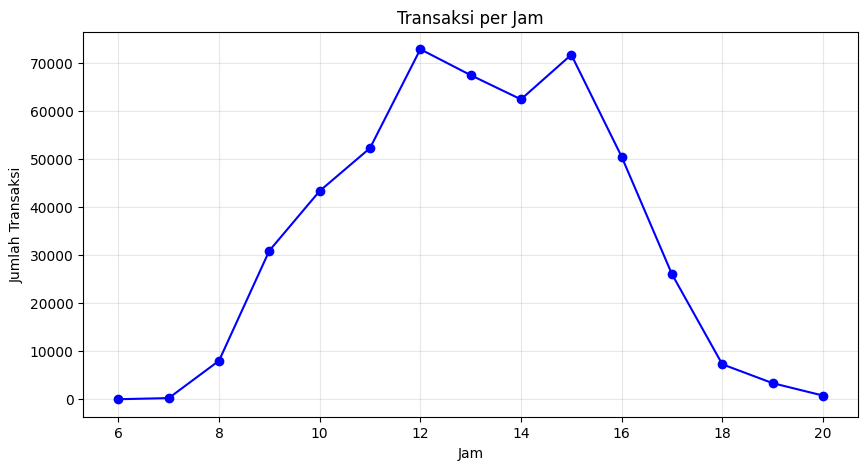

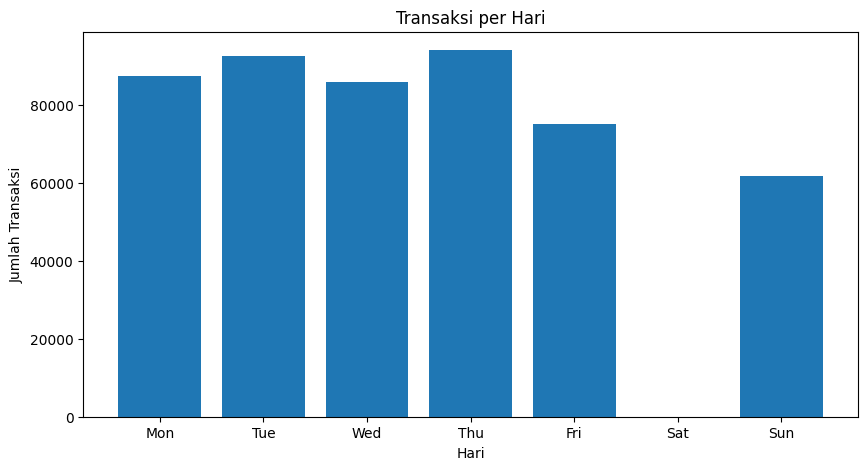

In [6]:
print("\n4.1 ANALISIS TEMPORAL (TEMPORAL ANALYSIS)")

df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['Day'] = df_clean['InvoiceDate'].dt.day
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.day_name()
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour
df_clean['IsWeekend'] = df_clean['DayOfWeek'].isin(['Saturday', 'Sunday'])

print(f"Rentang Tanggal: {df_clean['InvoiceDate'].min()} sampai {df_clean['InvoiceDate'].max()}")
print(f"\nTransaksi Berdasarkan Hari:")
print(df_clean['DayOfWeek'].value_counts().sort_index())

print(f"\nTransaksi Berdasarkan Jam:")
hourly_dist = df_clean['Hour'].value_counts().sort_index()
print(hourly_dist.head(10))



plt.figure(figsize=(10, 5))
hourly_counts = df_clean['Hour'].value_counts().sort_index()
plt.plot(hourly_counts.index, hourly_counts.values, marker='o', color='blue')
plt.title('Transaksi per Jam')
plt.xlabel('Jam')
plt.ylabel('Jumlah Transaksi')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 5))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df_clean['DayOfWeek'].value_counts().reindex(day_order)
plt.bar([d[:3] for d in day_order], day_counts.values)
plt.title('Transaksi per Hari')
plt.xlabel('Hari')
plt.ylabel('Jumlah Transaksi')
plt.show()


### 4.2 Product Analysis
identifikasi jumlah produk serta keunikan, revenue produk



4.2 ANALISIS PRODUK (PRODUCT ANALYSIS)
Total Produk Unik: 3,851
Total Deskripsi Unik: 3,955

Top 10 Produk Berdasarkan Revenue:
                                    Total_Revenue  Total_Quantity  \
Description                                                         
REGENCY CAKESTAND 3 TIER                109015.82            9319   
WHITE HANGING HEART T-LIGHT HOLDER       57061.26           19642   
PARTY BUNTING                            50629.16            8772   
JUMBO BAG RED RETROSPOT                  35492.46           15637   
SPOTTY BUNTING                           30609.41            5527   
ASSORTED COLOUR BIRD ORNAMENT            30411.73           17661   
JAM MAKING SET WITH JARS                 27634.90            6270   
CHOCOLATE HOT WATER BOTTLE               26950.52            4748   
SET OF 3 CAKE TINS PANTRY DESIGN         26750.07            5065   
CHILLI LIGHTS                            26152.26            4382   

                                    Jumlah

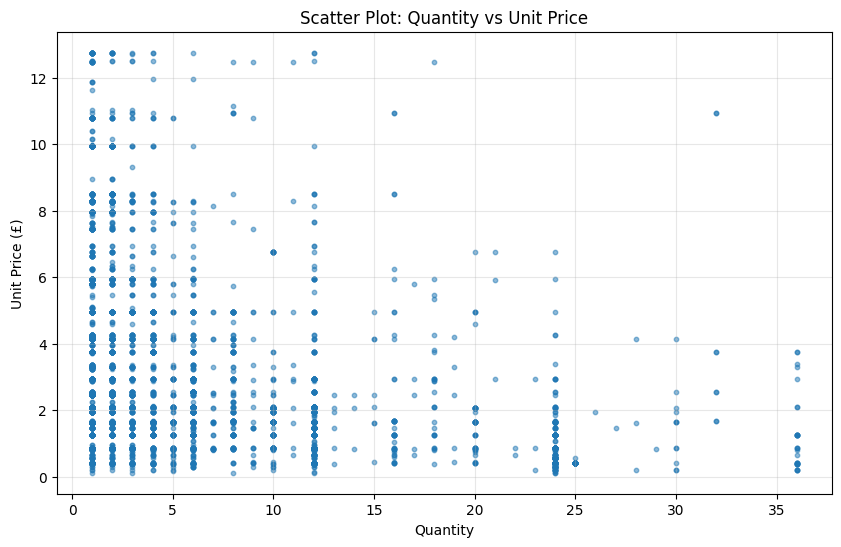

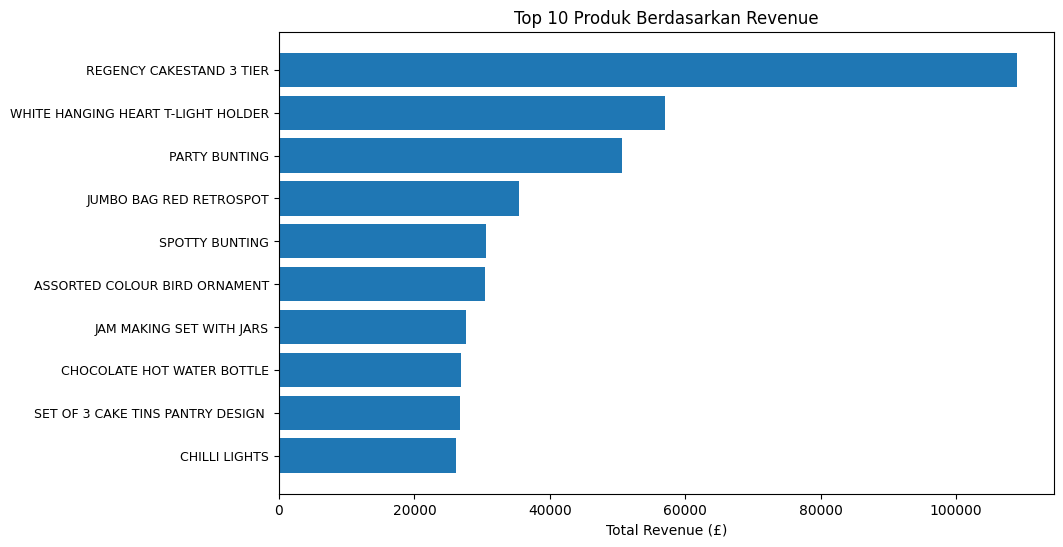

In [ ]:
print("\n4.2 ANALISIS PRODUK (PRODUCT ANALYSIS)")

print(f"Total Produk Unik: {df_clean['StockCode'].nunique():,}")
print(f"Total Deskripsi Unik: {df_clean['Description'].nunique():,}")

top_products = df_clean.groupby('Description').agg({
    'Revenue': 'sum',
    'Quantity': 'sum',
    'InvoiceNo': 'count'
}).sort_values('Revenue', ascending=False).head(10)
top_products.columns = ['Total_Revenue', 'Total_Quantity', 'Jumlah_Transaksi']
print(f"\nTop 10 Produk Berdasarkan Revenue:")
print(top_products)

plt.figure(figsize=(10, 6))
sample = df_clean.sample(n=min(5000, len(df_clean)))  
plt.scatter(sample['Quantity'], sample['UnitPrice'], alpha=0.5, s=10)
plt.title('Scatter Plot: Quantity vs Unit Price')
plt.xlabel('Quantity')
plt.ylabel('Unit Price (£)')
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(10, 6))
top_10_revenue = df_clean.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)
plt.barh(range(len(top_10_revenue)), top_10_revenue.values)
plt.yticks(range(len(top_10_revenue)), [desc[:35] for desc in top_10_revenue.index], fontsize=9)
plt.xlabel('Total Revenue (£)')
plt.title('Top 10 Produk Berdasarkan Revenue')
plt.gca().invert_yaxis()
plt.show()


### 4.3 Price Distribution Analysis
analisis distribusi harga (statistik, segmentasi, dan pola distribusi)




4.3 ANALISIS DISTRIBUSI HARGA (PRICE DISTRIBUTION)
Statistik Unit Price:
count    497408.000000
mean          2.982119
std           2.573986
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max          12.750000
Name: UnitPrice, dtype: float64

Distribusi Segmen Harga:
PriceSegment
Sangat Rendah (0-2)    233400
Rendah (2-5)           191058
Menengah (5-10)         61302
Tinggi (10-50)          11648
Sangat Tinggi (50+)         0
Name: count, dtype: int64


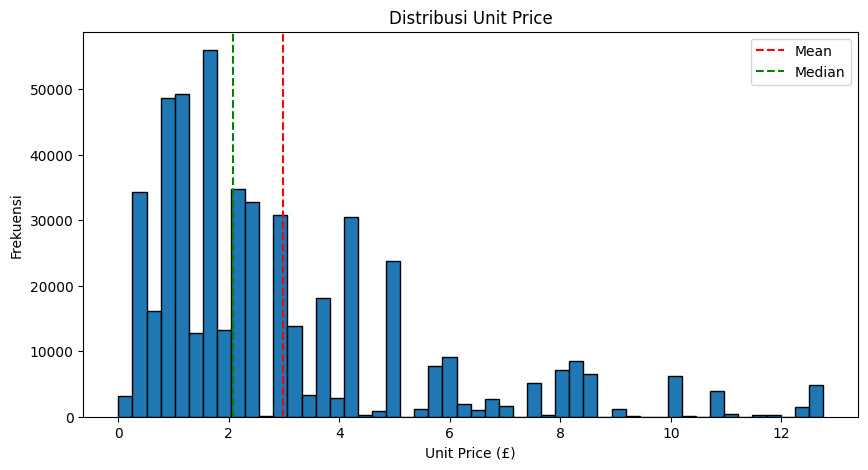

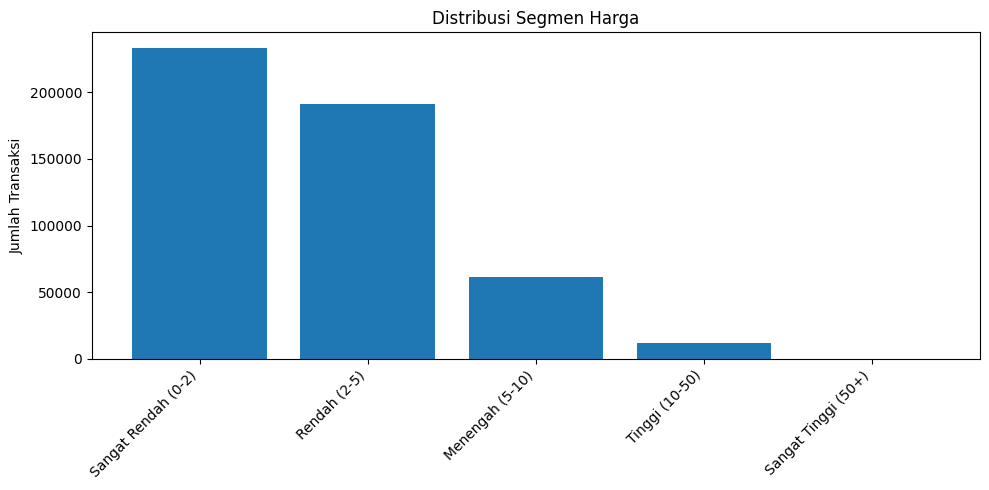

In [8]:
print("\n4.3 ANALISIS DISTRIBUSI HARGA (PRICE DISTRIBUTION)")

price_stats = df_clean['UnitPrice'].describe()
print("Statistik Unit Price:")
print(price_stats)

df_clean['PriceSegment'] = pd.cut(df_clean['UnitPrice'], 
                                   bins=[0, 2, 5, 10, 50, 1000],
                                   labels=['Sangat Rendah (0-2)', 'Rendah (2-5)', 'Menengah (5-10)', 
                                          'Tinggi (10-50)', 'Sangat Tinggi (50+)'])

print(f"\nDistribusi Segmen Harga:")
print(df_clean['PriceSegment'].value_counts().sort_index())

plt.figure(figsize=(10, 5))
plt.hist(df_clean['UnitPrice'], bins=50, edgecolor='black')
plt.title('Distribusi Unit Price')
plt.xlabel('Unit Price (£)')
plt.ylabel('Frekuensi')
plt.axvline(df_clean['UnitPrice'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(df_clean['UnitPrice'].median(), color='green', linestyle='--', label='Median')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
segment_counts = df_clean['PriceSegment'].value_counts().sort_index()
plt.bar(range(len(segment_counts)), segment_counts.values)
plt.xticks(range(len(segment_counts)), segment_counts.index, rotation=45, ha='right')
plt.title('Distribusi Segmen Harga')
plt.ylabel('Jumlah Transaksi')
plt.tight_layout()
plt.show()

### 4.4 Geographic Analysis
analisis pembeli dari negara mana, distribusi geografis penjualan.




4.4 ANALISIS GEOGRAFIS (GEOGRAPHIC ANALYSIS)
Total Negara: 38

Top 10 Negara Berdasarkan Jumlah Transaksi:
Country
United Kingdom    458727
Germany             8239
France              7684
EIRE                6946
Spain               2305
Belgium             1831
Switzerland         1788
Portugal            1417
Norway               909
Netherlands          785
Name: count, dtype: int64


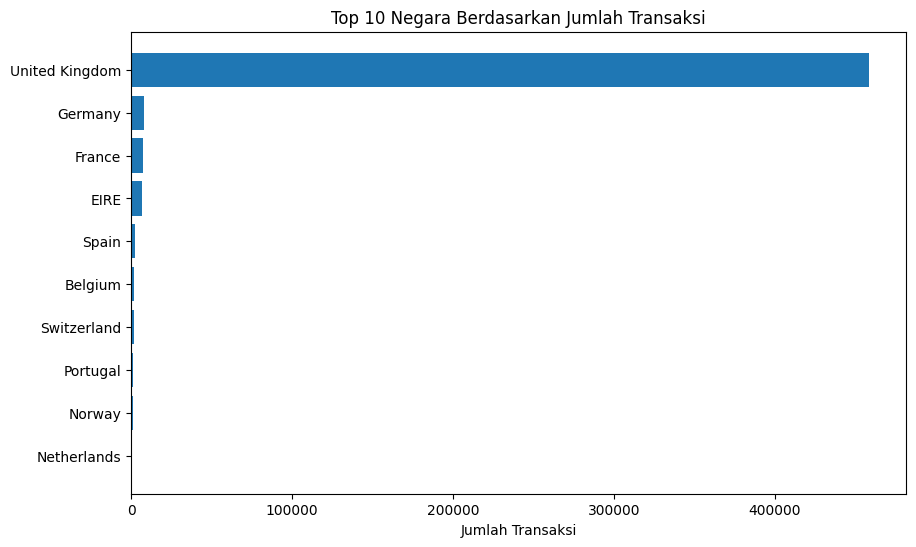

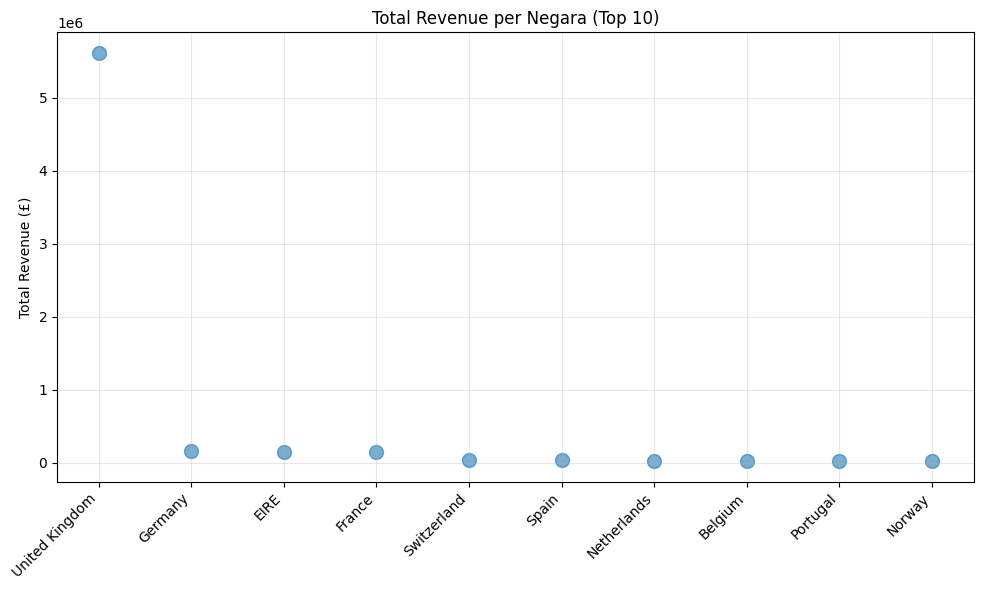

In [9]:
print("\n4.4 ANALISIS GEOGRAFIS (GEOGRAPHIC ANALYSIS)")

print(f"Total Negara: {df_clean['Country'].nunique()}")
print(f"\nTop 10 Negara Berdasarkan Jumlah Transaksi:")
country_stats = df_clean['Country'].value_counts().head(10)
print(country_stats)


plt.figure(figsize=(10, 6))
top_countries = df_clean['Country'].value_counts().head(10)
plt.barh(range(len(top_countries)), top_countries.values)
plt.yticks(range(len(top_countries)), top_countries.index)
plt.xlabel('Jumlah Transaksi')
plt.title('Top 10 Negara Berdasarkan Jumlah Transaksi')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 6))
country_revenue = df_clean.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)
plt.scatter(range(len(country_revenue)), country_revenue.values, s=100, alpha=0.6)
plt.xticks(range(len(country_revenue)), country_revenue.index, rotation=45, ha='right')
plt.ylabel('Total Revenue (£)')
plt.title('Total Revenue per Negara (Top 10)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Export data

In [10]:
print("DATA EXPORT")

df_clean.to_csv('cleaned_market_data.csv', index=False)
print("Exported: cleaned_market_data.csv")



DATA EXPORT
Exported: cleaned_market_data.csv
